# Overview
The BERT model was proposed in [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805). It stands for “Bidirectional Encoder Representation with Transformers”. To put it in simple words BERT extracts patterns or representations from the data or word embeddings by passing it through an encoder. The encoder itself is a transformer architecture that is stacked together. It is a bidirectional transformer which means that during training it considers the context from both left and right of the vocabulary to extract patterns or representations.   
![](https://huggingface.co/blog/assets/52_bert_101/BERT-size-and-architecture.png)

In [1]:
import torch
print(torch.__version__)
import transformers
print(transformers.__version__)
import numpy as np
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

2.3.0
4.40.2


/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
model = BertModel.from_pretrained('bert-base-uncased')
model.config

/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

# BERT-base Architecture Parameters Explained

## 1. Main Architecture Components
### Transformer Layers (`num_hidden_layers: 12`)
- BERT-base has 12 Transformer encoder layers
- Each layer contains:
  * Multi-head self attention
  * Feed-forward neural network
  * Layer normalization
  * Residual connections

### Attention Mechanism
- `num_attention_heads: 12`
  * Each layer has 12 attention heads
  * Each head processes a different part of the input
- `hidden_size: 768`
  * Dimension of hidden states
  * Each attention head processes 64-dimensional data (768/12 = 64)

### Feed-forward Network
- `intermediate_size: 3072`
  * Size of the intermediate layer in feed-forward network
  * 4 times the hidden size (768 * 4 = 3072)
  * Sequence: 768 → 3072 → 768 (with GELU activation)

## 2. Other Important Parameters
### Embedding and Sequence
- `vocab_size: 30522`
  * Size of the tokenizer vocabulary
- `max_position_embeddings: 512`
  * Maximum sequence length the model can handle
- `type_vocab_size: 2`
  * For segment embeddings (sentence A/B)

### Model Configuration
- `hidden_act: "gelu"`
  * Activation function used
- `layer_norm_eps: 1e-12`
  * Small constant for numerical stability
- `attention_probs_dropout_prob: 0.1`
  * Dropout rate for attention probabilities
- `hidden_dropout_prob: 0.1`
  * Dropout rate for fully connected layers

### Position Information
- `position_embedding_type: "absolute"`
  * Uses absolute position embeddings

In [3]:
# Display special tokens
special_tokens = tokenizer.special_tokens_map
print(special_tokens)

{'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}


## BERT Embeddings   
BERT can embed texts.

In [3]:
# Load pre-trained BERT model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased')

# Input text
sentence = "BERT is a transformer-based model for NLP tasks."

# Encode input
inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)

# Get hidden states
with torch.no_grad():
    outputs = model(**inputs)
    # Last layer hidden states (batch_size, seq_length, hidden_size)
    hidden_states = outputs.last_hidden_state

# Get [CLS] token representation as sentence embedding
sentence_embedding = hidden_states[:, 0, :]  # [CLS] embedding
print(sentence_embedding.shape)  # Output: torch.Size([1, 768])

torch.Size([1, 768])


In [4]:
sentences = [
    # NLP-related sentences
    "Deep learning models have transformed natural language processing.",  # More technical like S2/S3
    "Transformers have revolutionized NLP tasks.",
    "Natural language processing is advancing rapidly.",
    
    # Weather-related sentences
    "The weather is sunny and warm today.",
    "It might rain this afternoon.",
    "The temperature will drop tomorrow.",
    
    # Sports-related sentences
    "The basketball team won the championship.",
    "The NBA finals were incredibly exciting.",  # More basketball-specific like S7
    "The Lakers dominated the basketball season."  # More basketball-specific like S7
]

# Get embeddings for all sentences
embeddings = []
with torch.no_grad():
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
        outputs = model(**inputs).last_hidden_state
        embeddings.append(outputs[:, 0, :])  # Get [CLS] token embedding

# Convert to numpy and combine
embeddings_np = np.vstack([emb.numpy() for emb in embeddings])
print(embeddings_np.shape)  # Output: (9, 768)

(9, 768)


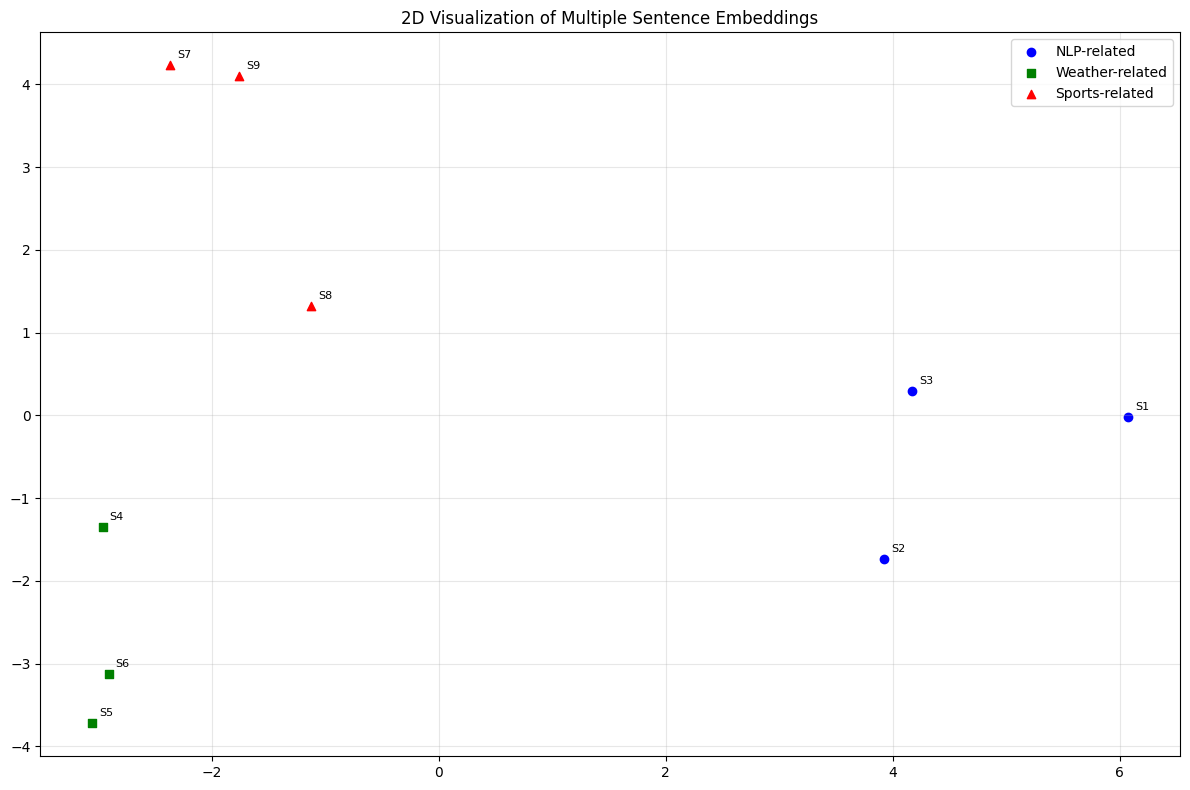

In [5]:
# Apply PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_np)

# Create scatter plot with different colors for different groups
plt.figure(figsize=(12, 8))

# Plot points by groups with different colors
colors = ['blue', 'green', 'red']
markers = ['o', 's', '^']

for i in range(3):  # Three groups
    start_idx = i * 3
    end_idx = start_idx + 3
    plt.scatter(embeddings_2d[start_idx:end_idx, 0], 
               embeddings_2d[start_idx:end_idx, 1], 
               c=colors[i], 
               marker=markers[i],
               label=f'Group {i+1}')

# Add labels for each point
for idx, sentence in enumerate(sentences):
    plt.annotate(f"S{idx+1}", 
                (embeddings_2d[idx, 0], embeddings_2d[idx, 1]),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=8)

# Customize plot
plt.title("2D Visualization of Multiple Sentence Embeddings")
plt.legend(['NLP-related', 'Weather-related', 'Sports-related'])
plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

## Masked Token Prediction   
BERT can predict the masked token(word). 

In [6]:
from transformers import BertForMaskedLM

# Load pre-trained model 
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()

# Prepare input text with [MASK] token
text = "The [MASK] is shining brightly in the sky."

# Encode the text
inputs = tokenizer(text, return_tensors="pt")

# Get the position of [MASK] token
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]

# Make prediction
with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits

# Get the predicted token
predicted_token_id = predictions[0, mask_token_index].argmax(axis=-1)
predicted_token = tokenizer.decode(predicted_token_id)

print(f"Input text: {text}")
print(f"BERT predicted word for [MASK]: {predicted_token}")

# Show top-5 predictions
probs = torch.nn.functional.softmax(predictions[0, mask_token_index], dim=-1)
top_5_tokens = torch.topk(probs, 5, dim=-1)

print("\nTop 5 predictions:")
for token, prob in zip(top_5_tokens.indices[0], top_5_tokens.values[0]):
    word = tokenizer.decode([token])
    print(f"{word}: {prob:.3f}")

/opt/miniconda3/envs/nlp/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Input text: The [MASK] is shining brightly in the sky.
BERT predicted word for [MASK]: sun

Top 5 predictions:
sun: 0.605
moon: 0.359
sunset: 0.006
star: 0.004
city: 0.002


## Next Sentence Prediction   
BERT can predict whether two sentences are related.

In [7]:
from transformers import BertForNextSentencePrediction
# Load pre-trained model
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
model.eval()

# Prepare example sentence pairs
sentence_pairs = [
    ["The restaurant is famous.", "Jupiter is the largest planet."],  # Unrelated sentences
    ["The weather is very cold.", "There is snow everywhere."],     # Related sentences
]

# Test each pair of sentences
for sentences in sentence_pairs:
    # Encode sentence pairs
    encoding = tokenizer(sentences[0], sentences[1], return_tensors='pt', padding=True)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(**encoding)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Get prediction probabilities
    is_next_prob = predictions[0][0].item()
    
    print(f"\nSentence 1: {sentences[0]}")
    print(f"Sentence 2: {sentences[1]}")
    print(f"Probability these sentences are related: {is_next_prob:.3f}")
    print(f"Probability these sentences are not related: {1-is_next_prob:.3f}")


Sentence 1: The restaurant is famous.
Sentence 2: Jupiter is the largest planet.
Probability these sentences are related: 0.000
Probability these sentences are not related: 1.000

Sentence 1: The weather is very cold.
Sentence 2: There is snow everywhere.
Probability these sentences are related: 1.000
Probability these sentences are not related: 0.000
